In [1]:
import cv2 as cv
import numpy as np
import sys
import torch
import torchvision
import torchvision.transforms as T
from cv2 import IMREAD_GRAYSCALE, IMREAD_COLOR
from deep_learning_project.load_data import get_transform
from deep_learning_project.net import LinearRegressionNetwork, FirstNeuralNetwork, SecondNeuralNetwork, FourthNeuralNetwork
from torch import nn
from torchvision.transforms import InterpolationMode
import math
import matplotlib.pyplot as plt
from copy import deepcopy

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = FirstNeuralNetwork()

model.load_state_dict(torch.load('models/20221110_1530_FirstNeuralNetwork/best_valid_weights.pt'))
model.eval()

classes = ['noface', 'face']

In [3]:
def predict(model, img):
    obj = None
    with torch.no_grad():
        # exploit the model
        logits = model(img)
        pred_probab = nn.Softmax(dim=1)(logits)
        y_pred = pred_probab.argmax(1).item() # indice(s) of the maximum value in the tensor
        obj = (y_pred, pred_probab)
    return obj

def np_to_np_image(array):
    return array.reshape((array.shape[0], array.shape[1], 1))

def print_image_gray(image):
    fig = plt.figure(figsize=(20, 30))
    rows = 1
    cols = 1
    fig.add_subplot(rows, cols, 1)

    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()

def print_all_feature_maps(feature_maps):
    fig = plt.figure(figsize=(20, 30))
    rows = math.ceil(len(feature_maps)/3)
    cols = 3

    for i, map in enumerate(feature_maps):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(map*255, cmap='gray', vmin=0, vmax=255)

    plt.show()

def print_image_color(image):
    fig = plt.figure(figsize=(20, 30))
    rows = 1
    cols = 1
    fig.add_subplot(rows, cols, 1)

    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    plt.show()

# def find_blobs(image, params):
#     detector = cv.SimpleBlobDetector_create(params)

#     # Detect blobs.
#     keypoints = detector.detect(image,)

#     # Draw detected blobs as red circles.
#     # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
#     im_with_keypoints = cv.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#     return keypoints, im_with_keypoints

# def find_all_blobs(images, params):
#     keypoints = []
#     imgs = []
    
#     for image in images:
#         keypoint, img = find_blobs(image, params)
        
#         for k in keypoint:
#             keypoints.append(k)

#         imgs.append(img)
    
#     return keypoints, imgs

# def prepare_feature_maps(feature_maps, resize_shape, threshold=0.9):
#     threshs = []
#     for i in range(len(feature_maps)):
#         ret, thresh = cv.threshold(feature_maps[i], threshold, 1, cv.THRESH_BINARY)
        
#         thresh = np_to_np_image(thresh)
#         thresh = (thresh*255).astype(np.uint8)
#         thresh = cv.resize(thresh, (resize_shape[1], resize_shape[0]))
#         thresh = np_to_np_image(thresh)

#         threshs.append(thresh)
    
#     return threshs

def sliding_windows(PIL_img: torch.Tensor, window_size = (36,36), scale=0.8, stride=1):
    image = PIL_img.clone()
    wx, wy = window_size

    feature_maps = []

    while (True):
        feature_map = []
        for y in range(0, image.size()[1] - wy, stride):

            feature_row = []
            for x in range(0, image.size()[2] - wx, stride):

                # crop and preparing the cropped image
                new_img = image[:, y:y+36, x:x+36]
                new_img = new_img.reshape((1, 1, 36, 36))

                (y_pred, pred_probab) = predict(model, new_img)
                
                # 0 = noface, 1 = face
                feature_row.append(pred_probab.squeeze()[1].item())

            feature_map.append(feature_row)

        if len(feature_map) != 0:
            feature_maps.append(feature_map)
        
        new_height = math.ceil(image.size()[1] * scale)
        new_width = math.ceil(image.size()[2] * scale)

        # stop the loop if the image is smaller than the retina
        if new_height < window_size[1] or new_width < window_size[0]:
            break

        image = T.Resize((new_height, new_width), interpolation=InterpolationMode.BILINEAR)(image)
    
    for i in range(len(feature_maps)):
        feature_maps[i] = np_to_np_image(np.array(feature_maps[i]))

    return feature_maps

def make_blob(feature_map, x, y, threshold, blob):
    if y >= feature_map.shape[0] or x >= feature_map.shape[1]:
        return
        
    if feature_map[y][x] > threshold:
        blob.append([y, x, feature_map[y][x]])

        # make current cell black
        feature_map[y][x] = 0

        # move all 4 direction
        make_blob(feature_map, x+1, y, threshold, blob)
        make_blob(feature_map, x, y+1, threshold, blob)
        make_blob(feature_map, x-1, y, threshold, blob)
        # make_blob(feature_map, x, y-1, threshold, blob)

def find_blob_maxes(blob):
    tmp = blob
    tmp.sort(key=lambda x: x[0])

    miny = tmp[0][0]
    maxy = tmp[-1][0]

    tmp.sort(key=lambda x: x[1])

    minx = tmp[0][1]
    maxx = tmp[-1][1]

    return (miny, maxy, minx, maxx)

def distance_between_blobs(blob1, blob2):
    dist = 999999999999

    b1 = np.array(blob1)
    b2 = np.array(blob2)

    cy1 = np.sum(b1[:,0])
    cy2 = np.sum(b2[:,0])

    cx1 = np.sum(b1[:,1])
    cx2 = np.sum(b2[:,1])

    cy1 /= len(blob1)
    cy2 /= len(blob2)

    cx1 /= len(blob1)
    cx2 /= len(blob2)

    dist = math.sqrt(math.pow(cy1 - cy2, 2) + math.pow(cx1 - cx2, 2))
    
    return dist

def merge_blobs(blobs, min_distance):
    n_blobs = len(blobs)
    pred = 0
    
    continueMerge = True

    while continueMerge:

        continueMerge = False

        for i in range(len(blobs)):
            for j in range(i+1, len(blobs)):
                
                if distance_between_blobs(blobs[i], blobs[j]) < min_distance:
                    a = blobs[i]
                    b = blobs[j]
                    
                    blobs.pop(j)
                    blobs.pop(i)

                    for x in b:
                        a.append(x)
                    
                    blobs.append(a)
                    continueMerge = True
                    break
            
            if continueMerge:
                break




def find_all_blobs(feature_maps, blob_threshold, blob_distance, img_shape):
    blobs = []

    for feature_map in feature_maps:
        cur_blobs = []

        feature_map = cv.resize(feature_map, (img_shape[1], img_shape[0]))

        feature_map_copy = deepcopy(feature_map)

        for y in range(feature_map_copy.shape[0]):
            for x in range(feature_map_copy.shape[1]):

                if feature_map_copy[y][x] > blob_threshold:
                    blob = []
                    make_blob(feature_map_copy, x, y, blob_threshold, blob)
                    cur_blobs.append(blob)
        
        merge_blobs(cur_blobs, blob_distance)

        for x in cur_blobs:
            blobs.append(x)

    return blobs


def blobs_to_boxes(blobs):
    boxes = []
    for blob in blobs:
        (miny, maxy, minx, maxx) = find_blob_maxes(blob)
        boxes.append([minx, miny, maxx, maxy])
    
    return np.array(boxes)

def blob_volume(blob):
    new_blob = np.apply_along_axis(arr=blob, func1d=lambda x: x[2], axis=1)
    return np.sum(new_blob)

def NMS(boxes, overlapThresh = 0.4): # https://towardsdatascience.com/non-maxima-suppression-139f7e00f0b5
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices
    return boxes[indices].astype(int)

In [4]:
# Image
img_src = cv.samples.findFile("zack.jpg")

img_color = cv.imread(img_src, IMREAD_COLOR)

print(img_color.shape)

(447, 568, 3)


In [5]:
# Transform the image
transform = get_transform()

transformed_image = transform(T.ToPILImage()(img_color))
print(transformed_image.shape)

torch.Size([1, 447, 568])


In [6]:
feature_maps = sliding_windows(PIL_img=transformed_image, stride=1, scale=0.9)

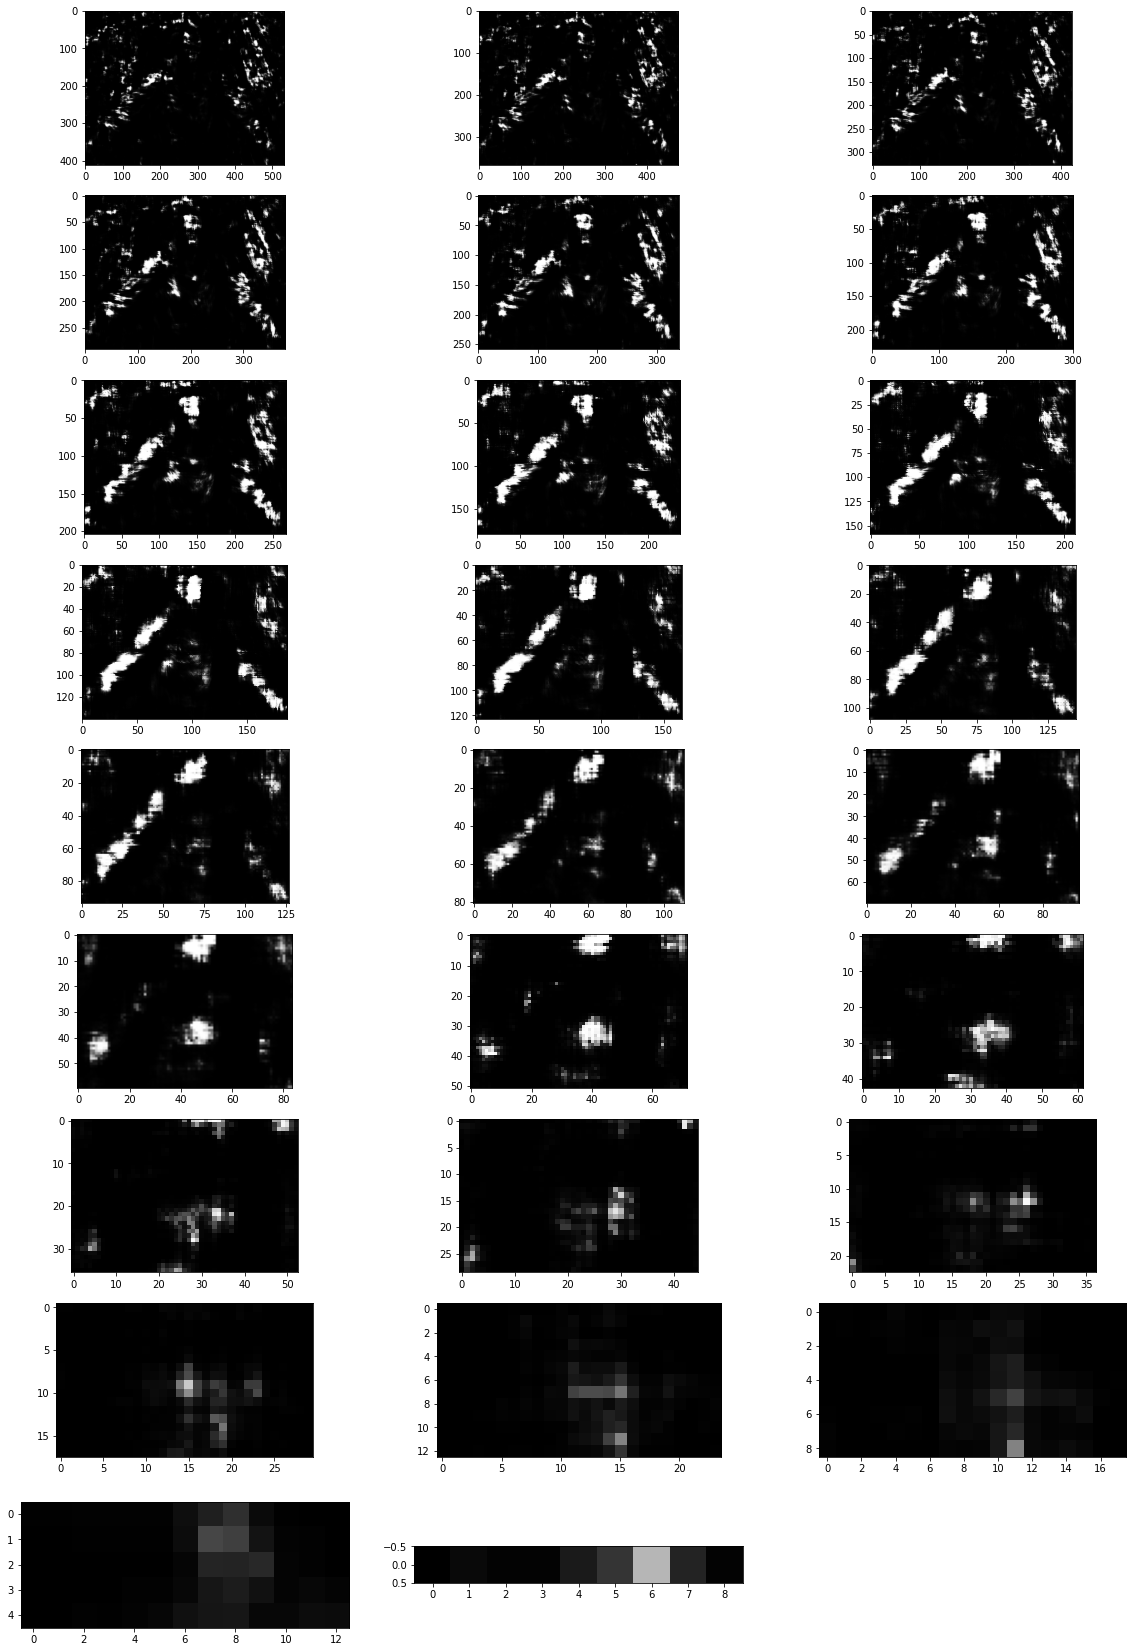

In [7]:
print_all_feature_maps(feature_maps)

In [8]:
# # Set up the detector with default parameters.
# params = cv.SimpleBlobDetector_Params()
# params.minThreshold = 200

# params.filterByArea = True
# params.minArea = 50
# params.filterByColor = True
# params.blobColor = 255
# params.filterByCircularity = False
# params.minCircularity = 0.1
# params.filterByConvexity = False
# params.filterByInertia = False
# params.minDistBetweenBlobs = 10

# threshs = prepare_feature_maps(feature_maps, img_color.shape, threshold=0.2)
# keypoints, imgs = find_all_blobs(threshs, params)

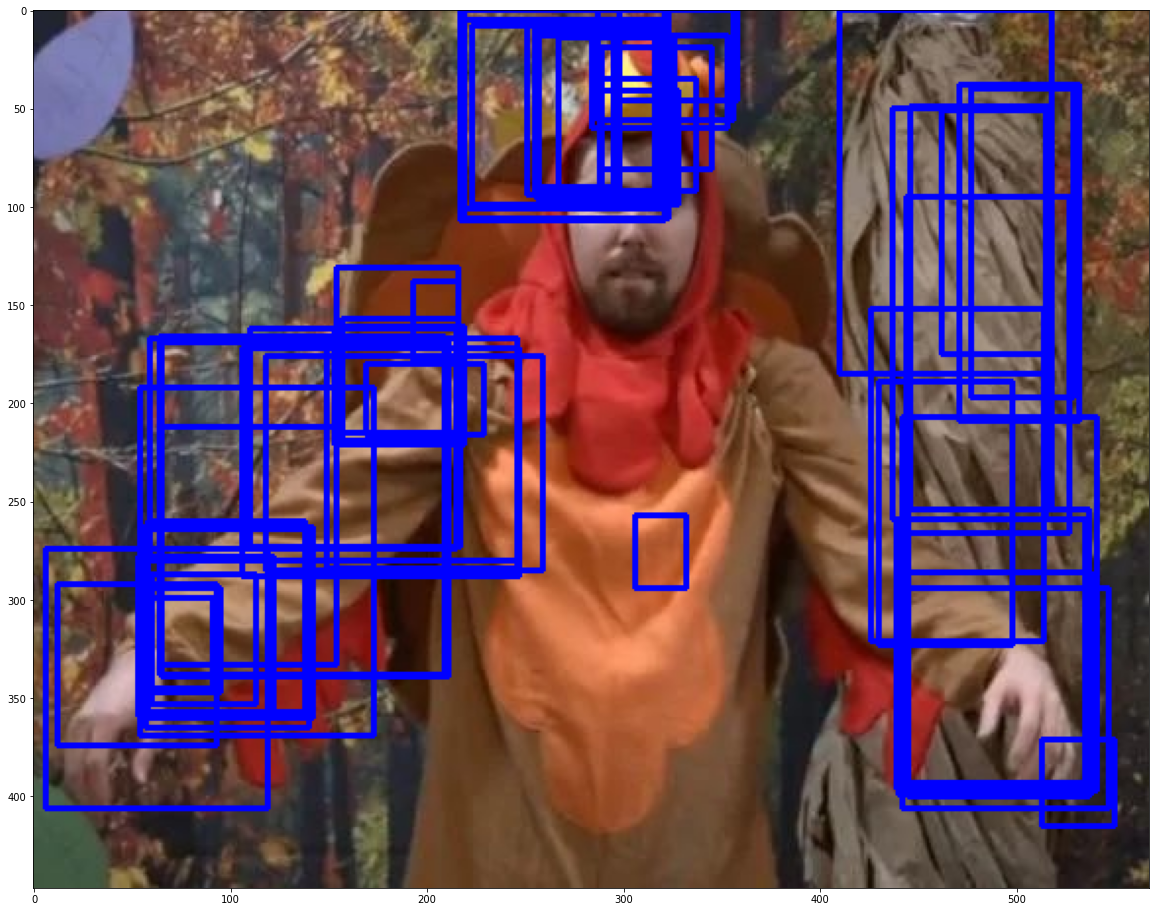

In [9]:
blobs = find_all_blobs(feature_maps, blob_threshold=0.995, blob_distance=100, img_shape=img_color.shape)
img = deepcopy(img_color)
filtered_blobs = list(filter(lambda x: blob_volume(x) > 100, blobs))
for blob in filtered_blobs:
    (miny, maxy, minx, maxx) = find_blob_maxes(blob)

    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2

    img = cv.rectangle(img, (minx, miny), (maxx, maxy), color, thickness)

print_image_color(img.astype(np.uint8))

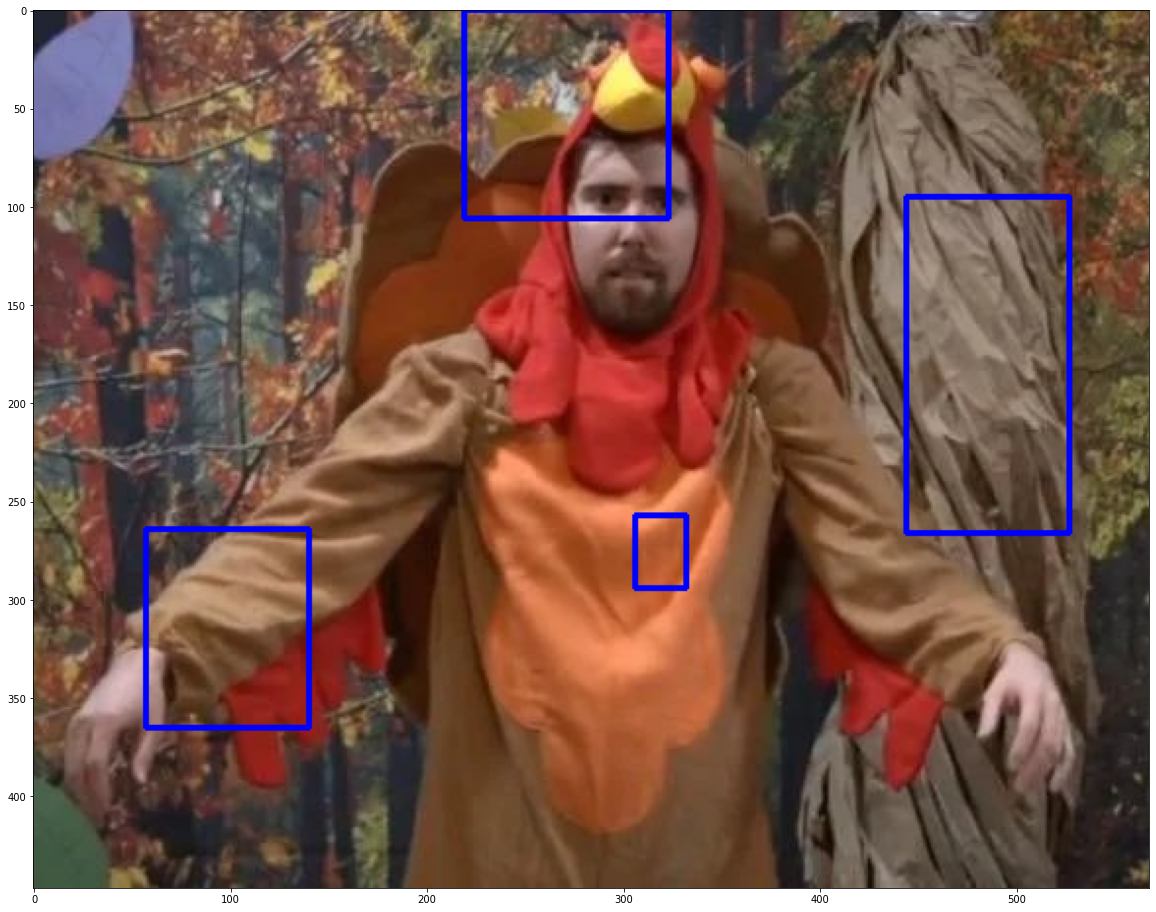

In [10]:

img2 = deepcopy(img_color)
filtered_blobs.sort(key=lambda x: blob_volume(x))
boxes = blobs_to_boxes(filtered_blobs)
nms = NMS(boxes, overlapThresh=0.9)

for box in nms:
    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2

    img2 = cv.rectangle(img2, (box[0], box[1]), (box[2], box[3]), color, thickness)

print_image_color(img2.astype(np.uint8))

In [11]:
# im_with_keypoints = cv.drawKeypoints(img_color, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# print_image_color(im_with_keypoints)

In [12]:
# print_image_gray(imgs[4])